# RedCap -> Proto-Dataset
This notebook converts the RedCAp export (COVID19?) into Proto-Dataset format

In [1]:
%load_ext autoreload
%autoreload 2
import os
import openpyxl as pyxl
import sys
import pandas as pd
import time
from datetime import datetime
import numpy as np
import generic_functions2 as gf

In [2]:
# Settings

config_file = 'REDCAP_configuration_proto.xlsx'
sheet_name='Settings'
settings_table = pd.read_excel(config_file, sheet_name=sheet_name, index_col='Item')

edc_folder = settings_table.loc['edc_folder']['Value']
if edc_folder[-1] != '/': edc_folder += '/'
proto_dataset_folder = settings_table.loc['proto_dataset_folder']['Value']
if proto_dataset_folder[-1] != '/': proto_dataset_folder += '/'

study_name = settings_table.loc['study_name']['Value']
recordid = settings_table.loc['recordid']['Value']
separator = settings_table.loc['separator']['Value']


# move Castor zips from inbox when manually uploaded to a Workspace
source_folder = 'z:/inbox/'
gf.move_files(study_name+'*.*', source_folder, edc_folder)

#extract potential zip files
gf.find_unpack_zips(edc_folder, 6)

# gf.print_title('Choose the source for the Study')
isaric_csv = edc_folder + gf.choose_dir_item(edc_folder,'files',study_name)

print('\n'*2)
gf.print_title('Processing, please relax and maybe grab a cup of coffee/tea ....')

******************************************************************************************
Choose source by number
------------------------------------------------------------------------------------------
[1]  ISARICCOVID19COREFol_DATA_2021-10-18_1555.csv	



Please choose Q(uit) or between 1 and 1:  1





******************************************************************************************
Processing, please relax and maybe grab a cup of coffee/tea ....
------------------------------------------------------------------------------------------


In [3]:
# function needed to merge rows properly
def day_temp(row):
    tocheck = 'redcap_event_name'
    if row[tocheck][0:3] == 'add':
        return 'day_' + str(14 + int(row['redcap_repeat_instance'])) + '_arm_1'
    else:
        return row[tocheck]

# reading the data
df_isaric = pd.read_csv(isaric_csv, sep=',', dtype='string')

## Creating Proto-ISARIC

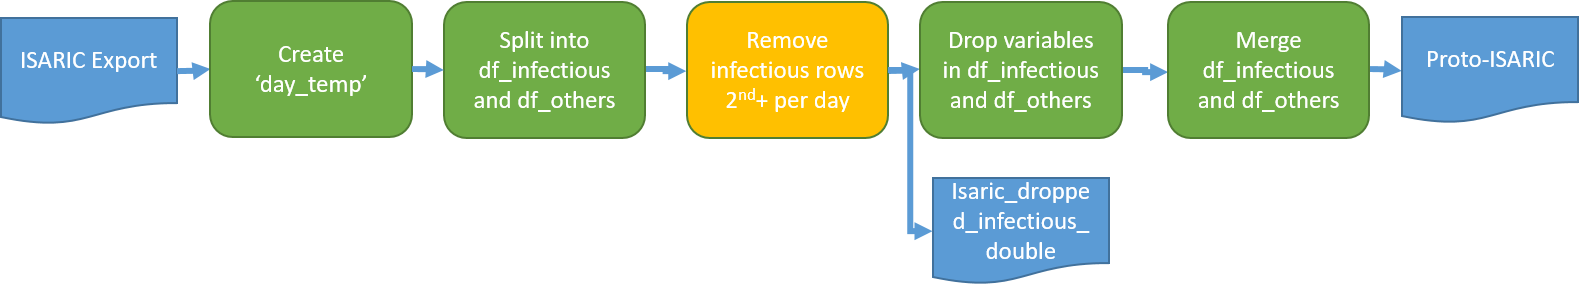

### Proto-ISARIC = proto-Dataset

In [4]:
# split & merge: ISARIC infectious needs to be merged on rows
## create day_temp to allow merge in later step
df_isaric['day_temp'] = df_isaric.apply(lambda row: day_temp(row), axis=1)
df_isaric['subjid'].astype(str)

## if redcap_repeat_instrument 
df_isaric['redcap_repeat_instrument'].fillna(' ', inplace=True)

## split df_isaric into df_isaric_infectious and df_isaric_other
check_on = 'infectious_respiratory_disease_pathogen_testing'
df_isaric_other = df_isaric[df_isaric['redcap_repeat_instrument'] != check_on].copy()


df_isaric_infectious = df_isaric[df_isaric['redcap_repeat_instrument'] == check_on].copy()



In [5]:
# maybe only specific for the COVID19 study at UMCG
## the instrument "infectious_respiratory_desease" is added event based, not per day
## events of the same day need to be grouped and concatenated per day
## this instrucment for discharge oucome is a specific case that needs to be grouped into one day
## this can be done in one pass

## grouping dailys
### list to group on
temp_list = ['subjid', 'redcap_event_name']

### replace all possible NANs
df_isaric_infectious.fillna('', inplace=True)

### aggreate everything
df_isaric_infections_joined = df_isaric_infectious.groupby(temp_list, as_index=False).agg({
    'redcap_repeat_instrument': 'first',
    'daily_mbperf': 'first',
    'mbdat': 'first',
#     'mbdat': ','.join,
    'other_mbspec': ','.join,
    'mbmethod': ','.join,
    'other_mbmethod': ','.join,
    'mborres': ','.join,
    'mbtestcd': ','.join,
    'infectious_respiratory_disease_pathogen_testing_complete': ','.join,
    'day_temp': 'first'
    
})

### removing 'doubles' in the join, make sure only unique values are displayed
def replace_with_unique(row, item):
    row[item] = ','.join(set(row[item].split(',')))
    return row[item]

temp_list = ['other_mbspec', 'mbmethod', 'other_mbmethod', 'mborres', 'mbtestcd', 'infectious_respiratory_disease_pathogen_testing_complete']
for item in temp_list:
    df_isaric_infections_joined[item] = df_isaric_infections_joined.apply(lambda row: replace_with_unique(row, item), axis=1)

gf.output_csv(df_isaric_infections_joined, proto_dataset_folder + 'df_isaric_infections_joined', False)


saved: ./proto-Dataset/df_isaric_infections_joined.csv


'saved: ./proto-Dataset/df_isaric_infections_joined.csv'

In [6]:
# # some changes were made, impact not yet known

# ## don't know for sure how to deal with it, there are more infectious then other, should
# ## not be possible: correction below: drop all
# temp_list = ['subjid', 'redcap_event_name', 'redcap_repeat_instrument', 'day_temp']
# temp1 = df_isaric_infectious['subjid'].count()
# # df_isaric_infectious2 = df_isaric_infectious.groupby(temp_list).head(1).copy()
# df_isaric_infectious2 = df_isaric_infections_joined.copy() #.groupby(temp_list).head(1).copy()
# # print(df_isaric_infectious2)
# # gf.output_csv(df_isaric_infectious2, proto_dataset_folder + 'df_isaric_infectious2', False)

# # df_dropped = df_isaric_infectious[~df_isaric_infectious.apply(tuple,1).isin(df_isaric_infectious2.apply(tuple,1))]
# # temp2 = df_isaric_infectious2['subjid'].count()
# # if temp1 > temp2:
# #     print('='*60)
# #     print("Records were deleted. \n\nFor 'redcap_repeat_instrument'")
# #     print("'infectious_respiratory_disease_pathogen_testing'\n\n")
# #     print('contained more than 1 entry for a specific day. \n\nOnly first record is preserved')
# #     print('-'*60)
# #     print(f'\n# of records deleted: {temp1-temp2}\n')
# #     print('='*60)
# #     gf.output_csv(df_dropped, proto_dataset_folder + 'isaric_dropped_infectious_double')
# #     while True:
# #         choice = input('C(ontinue) or S(top)?')
# #         if choice in ['C', 'c']:
# #             df_isaric_infectious = df_isaric_infectious2.copy()
# #             break
# #         if choice in ['S', 's']:
# #             sys.exit()
# #         else:
# #             print("Please respond with 'S' or 'C'\n")

# df_isaric_infectious = df_isaric_infectious2.copy()


df_isaric_infectious = df_isaric_infections_joined.copy()
## list with all infectious variables
sheet_name='infectious_variables'
infectious_variables = pd.read_excel(config_file, sheet_name=sheet_name, index_col=None, usecols="A").iloc[:,0].tolist()

## list with all base_first variables
sheet_name='base_first'
base_first = pd.read_excel(config_file, sheet_name=sheet_name, index_col=None, usecols="A").iloc[:,0].tolist()

## list with all base_first variables
sheet_name='base_last'
base_last = pd.read_excel(config_file, sheet_name=sheet_name, index_col=None, usecols="A").iloc[:,0].tolist()



## drop all infectious variables from df_isaric_other
for item in infectious_variables:
    # in case a variable doesn't exist
    try:
        df_isaric_other1 = df_isaric_other.drop(item, axis=1)
    except:
        pass

             
# ## drop all but infectious variables, day_temp and subjid from df_isaric_infectious
# infectious_variables_plus = infectious_variables + ['subjid', 'day_temp']
# non_infectious_variables = [x for x in list(df_isaric_other.columns) if x not in infectious_variables_plus]
# df_isaric_infectious1 = df_isaric_infectious.drop(non_infectious_variables, axis=1)

## merge df_isaric_infecious with df_isaric_other
merge_variables = ['subjid', 'day_temp']
# df_isaric_flat = pd.merge(df_isaric_other1, df_isaric_infectious1, how ='left', left_on=merge_variables, right_on=merge_variables)
df_isaric_flat = pd.merge(df_isaric_other1, df_isaric_infectious, how ='left', left_on=merge_variables, right_on=merge_variables)

## drop day_temp
df_isaric_flat.drop('day_temp', axis=1, inplace=True)

# gf.output_csv(df_isaric_flat, proto_dataset_folder + 'proto-dataset', False)




In [9]:
'''
This cell makes sure that all 'base' values in the first day is copied to each day, and
that all 'base' values in outcome (last) is copied to each day
''' 

# getting the unique data subjects
unique = list(set(df_isaric_flat[recordid]))

# iterate through each data subject
for item in unique:
    df_temp = df_isaric_flat.loc[df_isaric_flat[recordid] == item]
    # iterate through each base_first, get the value of first entry, adding to all days
    for col in base_first:
        try:
            v = df_temp[col].loc[df_temp.first_valid_index()]
            df_isaric_flat.loc[df_isaric_flat[recordid] == item, col] = v
        except:
            pass
    # iterate through each base_last, get the value of last entry, adding to all days
    for col in base_last:
        try:
            v = df_temp[col].loc[df_temp.last_valid_index()]
            df_isaric_flat.loc[df_isaric_flat[recordid] == item, col] = v
        except:
            pass

In [10]:
# creating the output: xlsx and csv
df_isaric_flat.to_excel(proto_dataset_folder + 'proto_dataset.xlsx', index=False)
gf.output_csv(df_isaric_flat, proto_dataset_folder + 'proto-dataset', False)

input('Enter to continue....')
print('\n'*2)
gf.print_title('Finished creating Proto-'+study_name)

saved: ./proto-Dataset/proto-dataset.csv


Enter to continue.... 





******************************************************************************************
Finished creating Proto-ISARICCOVID19
------------------------------------------------------------------------------------------
